구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


파일 경로 설정

In [2]:
import os
workspace_path = '/gdrive/My Drive/Dacon/Jeju_Specialty_Product_Price_Prediction_AI'  # 과제 파일 업로드한 경로 반영
data_path = os.path.join(workspace_path, 'data')  # 데이터 파일 경로 반영

패키지 불러오기

In [3]:
# 경고 무시
import warnings
warnings.filterwarnings(action='ignore')

# 필요 패키지 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

#제주도 특산물 가격 예측 AI

데이터 불러오기

In [4]:
train = pd.read_csv(os.path.join(data_path,'train.csv'))
train

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0
...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0


In [5]:
test = pd.read_csv(os.path.join(data_path,'test.csv'))
test

,ID,timestamp,item,corporation,location
0,TG_A_J_20230304,2023-03-04,TG,A,J
1,TG_A_J_20230305,2023-03-05,TG,A,J
2,TG_A_J_20230306,2023-03-06,TG,A,J
3,TG_A_J_20230307,2023-03-07,TG,A,J
4,TG_A_J_20230308,2023-03-08,TG,A,J
...,...,...,...,...,...
1087,RD_F_J_20230327,2023-03-27,RD,F,J
1088,RD_F_J_20230328,2023-03-28,RD,F,J
1089,RD_F_J_20230329,2023-03-29,RD,F,J
1090,RD_F_J_20230330,2023-03-30,RD,F,J


In [6]:
submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
submission

,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0
...,...,...
1087,RD_F_J_20230327,0
1088,RD_F_J_20230328,0
1089,RD_F_J_20230329,0
1090,RD_F_J_20230330,0


In [7]:
trade = pd.read_csv(os.path.join(data_path, 'international_trade.csv'))
trade

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38
...,...,...,...,...,...,...,...
1269,2023-02,포포(papaw)[파파야(papaya)],0,0,23830,71,-71
1270,2023-02,사과,135165,351,0,0,351
1271,2023-02,배,2206012,5411,1,0,5411
1272,2023-02,신 체리[프루너스 체라서스(Prunus cerasus)],5,0,0,0,0


기본 정보 확인


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59397 entries, 0 to 59396
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           59397 non-null  object 
 1   timestamp    59397 non-null  object 
 2   item         59397 non-null  object 
 3   corporation  59397 non-null  object 
 4   location     59397 non-null  object 
 5   supply(kg)   59397 non-null  float64
 6   price(원/kg)  59397 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.2+ MB


In [9]:
train.describe()

,supply(kg),price(원/kg)
count,5.939700e+04,59397.000000
mean,1.189453e+04,1131.680674
std,5.226400e+04,2029.941445
min,0.000000e+00,0.000000
25%,0.000000e+00,0.000000
50%,0.000000e+00,0.000000
75%,3.800000e+03,1519.000000
max,1.222800e+06,20909.000000


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           1092 non-null   object
 1   timestamp    1092 non-null   object
 2   item         1092 non-null   object
 3   corporation  1092 non-null   object
 4   location     1092 non-null   object
dtypes: object(5)
memory usage: 42.8+ KB


결측치 재확인

In [11]:
print(train.isnull().sum())

ID             0
timestamp      0
item           0
corporation    0
location       0
supply(kg)     0
price(원/kg)    0
dtype: int64


In [12]:
print(test.isnull().sum())

ID             0
timestamp      0
item           0
corporation    0
location       0
dtype: int64


train, test 데이터 기간 확인

In [13]:
train_min_date = train['timestamp'].min()
train_max_date = train['timestamp'].max()

test_min_date = test['timestamp'].min()
test_max_date = test['timestamp'].max()

display(f"train 데이터 기간 : {train_min_date} ~ {train_max_date}")
display(f"test 데이터 기간 : {test_min_date} ~ {test_max_date}")

'train 데이터 기간 : 2019-01-01 ~ 2023-03-03'

'test 데이터 기간 : 2023-03-04 ~ 2023-03-31'

데이터 전처리

In [14]:
# ID 컬럼 제거
train = train.drop(['ID'], axis = 1)
test = test.drop(['ID'], axis = 1)

In [ ]:
# train.reset_index(inplace = True)
# train

In [ ]:
# train = train.drop(['index'], axis = 1)
# train

In [15]:
# timestamp 컬럼 이용 컬럼 추가
train['year'] = train['timestamp'].apply(lambda x: int(x[0:4]))
train['month'] = train['timestamp'].apply(lambda x: int(x[5:7]))
train['day'] = train['timestamp'].apply(lambda x: int(x[8:10]))
train['weekday'] = pd.to_datetime(train['timestamp']).dt.weekday

test['year'] = test['timestamp'].apply(lambda x: int(x[0:4]))
test['month'] = test['timestamp'].apply(lambda x: int(x[5:7]))
test['day'] = test['timestamp'].apply(lambda x: int(x[8:10]))
test['weekday'] = pd.to_datetime(test['timestamp']).dt.weekday

# 주말 컬럼 추가
train['weekend'] = train.apply(lambda x: 1 if x['weekday'] in [5, 6] else 0, axis=1)
test['weekend'] = test.apply(lambda x: 1 if x['weekday'] in [5, 6] else 0, axis=1)

# 계절 컬럼 추가
train['season'] = train['month'].apply(lambda x : 1 if x in [1,2,3] else 2 if x in [4,5,6] else 3 if x in [7,8,9] else 4)
test['season'] = test['month'].apply(lambda x : 1 if x in [1,2,3] else 2 if x in [4,5,6] else 3 if x in [7,8,9] else 4)

In [17]:
train = train.drop('timestamp', axis = 1)
test = test.drop('timestamp', axis = 1)

In [18]:
print(train['item'].value_counts())

TG    15230
BC    13707
RD    12184
CR    10661
CB     7615
Name: item, dtype: int64


In [19]:
# item 컬럼 인코딩
str_col = ['item', 'corporation', 'location']
for i in str_col:
  le = LabelEncoder() # LabelEncoder 클래스의 객체 생성
  le=le.fit(train[i]) #train 데이터 item 컬럼값 이용 훈련
  train[i]=le.transform(train[i]) # train 데이터 item 컬럼값 변환

  # test 데이터 item 고유 컬럼값에 대해 반복
  # 고유한 값을 처리하기 위해선 train 데이터에 이미 존재하는 클래스로 인코딩 해야함
  # = train 데이터와 test 데이터의 일관성 유지
  for label in np.unique(test[i]):
    if label not in le.classes_: # test 데이터 각 고유값이 train 데이터에 없는 경우
      le.classes_ = np.append(le.classes_, label) # 해당 값을 LabelEncoder classes에 저장(새로운 값 처리)
  test[i]=le.transform(test[i]) # test 데이터 item 컬럼값 변환

# 인코딩 된 데이터 확인
print(train['item'].value_counts())
print(train['corporation'].value_counts())
print(train['location'].value_counts())

4    15230
0    13707
3    12184
2    10661
1     7615
Name: item, dtype: int64
0    13707
4    13707
3    12184
2     9138
1     7615
5     3046
Name: corporation, dtype: int64
0    35029
1    24368
Name: location, dtype: int64


###international_trade 데이터 확인

international_trade 데이터의 수출입 금액 컬럼(단위:1000달러) -> 단위: 원으로 변경


In [20]:
# exchange_rate = 1300

# trade['수출 금액'] = trade['수출 금액'] * exchange_rate
# trade['수입 금액'] = trade['수입 금액'] * exchange_rate
# trade

무역수지

->이 수치가 0보다 크면 수출 규모가 수입보다 큼을 의미

In [21]:
trade.무역수지.value_counts()

 0       115
 1        16
 3        10
-2         9
 7         8
        ... 
-156       1
 1178      1
 312       1
-3238      1
 5411      1
Name: 무역수지, Length: 847, dtype: int64

price, supply가 각각 0인 행만 빼오기

In [ ]:
# # supply가 0인 경우 제외
# train_supply_zero = train[train['supply(kg)'] == 0]
# train_supply_zero.reset_index(inplace = True)
# train_supply_zero = train_supply_zero.drop('index', axis = 1)

# # price가 0인 경우 제외
# train_price_zero = train[train['price(원/kg)'] == 0]
# train_price_zero.reset_index(inplace = True)
# train_price_zero = train_price_zero.drop('index', axis = 1)

In [ ]:
# train_price_zero

In [ ]:
# print('item')
# print(train_price_zero.item.value_counts())

# print('corporation')
# print(train_price_zero.corporation.value_counts())

# print('location')
# print(train_price_zero.location.value_counts())

# print('month')
# print(train_price_zero.month.value_counts())

# # 날씨가 추울 때가 다른 계절 때보다 더 안팔림
# print('season')
# print(train_price_zero.season.value_counts())

# # 일요일이 다른 요일 보다 더 안팔림
# print('weekday')
# print(train_price_zero.weekday.value_counts())

In [22]:
print(f"가격 중 0원 비율 {round(sum(train['price(원/kg)']==0) / len(train) * 100, 4)}%")

가격 중 0원 비율 59.6916%


In [23]:
train[train["price(원/kg)"]!=0].groupby("year").median()

,item,corporation,location,supply(kg),price(원/kg),month,day,weekday,weekend,season
year,,,,,,,,,,
2019,4.0,2.0,0.0,7536.5,1904.5,4.0,16.0,2.0,0.0,2.0
2020,4.0,3.0,0.0,6277.5,2050.0,4.0,16.0,2.0,0.0,2.0
2021,3.0,2.0,0.0,7552.0,1874.5,4.0,16.0,2.0,0.0,2.0
2022,3.0,2.0,0.0,5880.0,2278.0,5.0,16.0,2.0,0.0,2.0
2023,3.0,2.0,0.0,11571.0,2088.0,2.0,14.0,3.0,0.0,1.0


<Axes: >

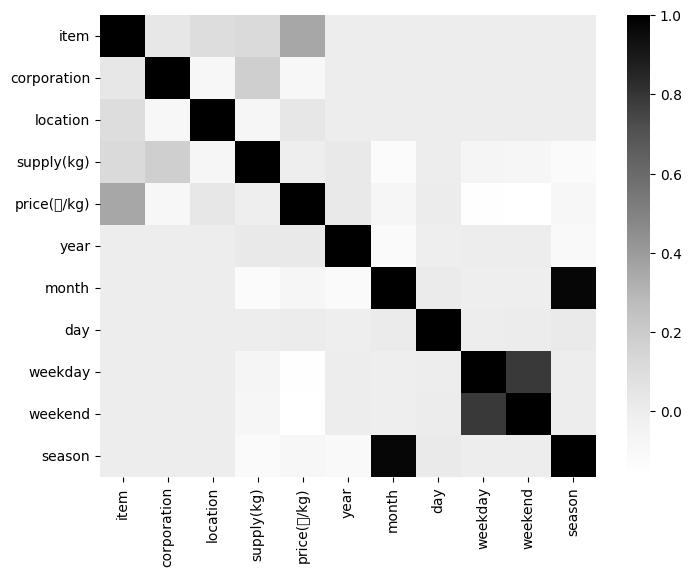

In [24]:
plt.figure(figsize=(8,6))
sns.heatmap(train.corr(), cmap='Greys')

In [25]:
# 0.TG : 감귤, 1.BC : 브로콜리, 2.RD : 무, 3.CR : 당근, 4.CB : 양배추
df1= pd.pivot_table(train,index='item',values='price(원/kg)',aggfunc='sum')
df1['비율'] = (df1['price(원/kg)']/df1['price(원/kg)'].sum())*100
df1

,price(원/kg),비율
item,,
0,12476065.0,18.560481
1,1158905.0,1.724088
2,2911721.0,4.331730
3,2279304.0,3.390891
4,48392442.0,71.992811


In [26]:
train[train['corporation']==5]

,item,corporation,location,supply(kg),price(원/kg),year,month,day,weekday,weekend,season
56351,1,5,0,0.0,0.0,2019,1,1,1,0,1
56352,1,5,0,0.0,0.0,2019,1,2,2,0,1
56353,1,5,0,67320.0,478.0,2019,1,3,3,0,1
56354,1,5,0,23584.0,600.0,2019,1,4,4,0,1
56355,1,5,0,48928.0,536.0,2019,1,5,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...
59392,3,5,0,452440.0,468.0,2023,2,27,0,0,1
59393,3,5,0,421980.0,531.0,2023,2,28,1,0,1
59394,3,5,0,382980.0,574.0,2023,3,1,2,0,1
59395,3,5,0,477220.0,523.0,2023,3,2,3,0,1


In [27]:
df2 = pd.pivot_table(train,index='corporation',values='price(원/kg)',aggfunc='sum')
df2['비율'] = (df2['price(원/kg)']/df2['price(원/kg)'].sum())*100
df2

,price(원/kg),비율
corporation,,
0,15649343.0,23.281325
1,11763166.0,17.499910
2,13418396.0,19.962374
3,12490909.0,18.582564
4,13107338.0,19.499617
5,789285.0,1.174209


In [28]:
df3 = pd.pivot_table(train,index='location',values='price(원/kg)',aggfunc='sum')
df3['비율'] = (df3['price(원/kg)']/df3['price(원/kg)'].sum())*100
df3

,price(원/kg),비율
location,,
0,37213110.0,55.361463
1,30005327.0,44.638537


In [29]:
trade['품목명'].value_counts()

감귤                                                                               50
포포(papaw)[파파야(papaya)]                                                           50
레몬[시트러스 리몬(Citrus limon)ㆍ시트러스 리머늄(Citrus limonum)]                               50
그레이프프루트(grapefruit)와 포멜로(pomelo)                                                 50
오렌지                                                                              50
망고(mango)                                                                        50
파인애플                                                                             50
무화과                                                                              50
대추야자                                                                             50
사과                                                                               50
오이류(신선한 것이나 냉장한 것으로 한정한다)                                                        50
당근                                                                          

In [30]:
selected_items = ['감귤', '브로콜리', '무', '당근', '양배추']
new_trade = trade[trade['품목명'].str.contains('|'.join(selected_items))]
new_trade

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38
5,2019-01,양배추,184650,94,395802,90,4
8,2019-01,당근,23150,22,7466150,2955,-2934
12,2019-01,무화과,2627,23,94529,464,-441
...,...,...,...,...,...,...,...
1250,2023-02,양배추,13188,13,377456,104,-91
1253,2023-02,당근,22510,20,9260020,3758,-3737
1254,2023-02,순무,4000,4,2,0,4
1258,2023-02,무화과,1319,14,104566,454,-440


In [31]:
new_trade['품목명'].value_counts()

꽃양배추와 브로콜리(broccoli)    50
방울다다기 양배추               50
양배추                     50
당근                      50
무화과                     50
감귤                      50
순무                       6
Name: 품목명, dtype: int64

In [32]:
new_trade = new_trade[new_trade['품목명'] != '무화과']
new_trade['품목명'].value_counts()

꽃양배추와 브로콜리(broccoli)    50
방울다다기 양배추               50
양배추                     50
당근                      50
감귤                      50
순무                       6
Name: 품목명, dtype: int64

In [33]:
# 0.TG : 감귤, 1.BC : 브로콜리, 2.RD : 무, 3.CR : 당근, 4.CB : 양배추
new_trade['품목명'] = new_trade['품목명'].replace('꽃양배추와 브로콜리(broccoli)', 'BC')
new_trade['품목명'] = new_trade['품목명'].replace('브로콜리', 'BC')
new_trade['품목명'] = new_trade['품목명'].replace('방울다다기 양배추', 'CB')
new_trade['품목명'] = new_trade['품목명'].replace('양배추', 'CB')
new_trade['품목명'] = new_trade['품목명'].replace('당근', 'CR')
new_trade['품목명'] = new_trade['품목명'].replace('감귤', 'TG')
new_trade['품목명'] = new_trade['품목명'].replace('무', 'RD')
new_trade['품목명'] = new_trade['품목명'].replace('순무', 'RD')
new_trade['품목명'].value_counts()

CB    100
BC     50
CR     50
TG     50
RD      6
Name: 품목명, dtype: int64

In [34]:
new_trade

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
3,2019-01,BC,160,1,638913,563,-562
4,2019-01,CB,0,0,7580,38,-38
5,2019-01,CB,184650,94,395802,90,4
8,2019-01,CR,23150,22,7466150,2955,-2934
17,2019-01,TG,58368,172,0,0,172
...,...,...,...,...,...,...,...
1249,2023-02,CB,71,1,10362,55,-55
1250,2023-02,CB,13188,13,377456,104,-91
1253,2023-02,CR,22510,20,9260020,3758,-3737
1254,2023-02,RD,4000,4,2,0,4


In [35]:
# price를 answer로 컬럼명 변경
train = train.rename(columns={'price(원/kg)':'answer'})

In [36]:
train['answer'].value_counts()

0.0       35455
500.0        50
1000.0       45
550.0        42
400.0        41
          ...  
6234.0        1
5686.0        1
5818.0        1
5652.0        1
655.0         1
Name: answer, Length: 7094, dtype: int64

In [39]:
# # trade 데이터에서 필요한 컬럼만 선택
# trade_sub = new_trade[['기간', '품목명', 'trade_price']]

# # '기간' 컬럼을 datetime 형식으로 변환
# trade_sub['기간'] = pd.to_datetime(trade_sub['기간'], format='%Y-%m')

# # '년도' 및 '월' 컬럼 추가
# trade_sub['년도'] = trade_sub['기간'].dt.year
# trade_sub['월'] = trade_sub['기간'].dt.month

# # train 데이터와 trade 데이터를 '년도'와 '월'을 기준으로 병합
# merged_train = pd.merge(train, trade_sub, how='left', left_on=['year', 'month', 'item'], right_on=['년도', '월', '품목명'])

# # 필요없는 컬럼 제거
# merged_train.drop(['기간', '품목명', '년도', '월'], axis=1, inplace=True)

# # 결과 확인
# merged_train['trade_price'] = merged_train['trade_price'].replace([np.inf, -np.inf], 0)

# # 전체 'trade_price' 열의 NaN 값을 중간값으로 대체
# merged_train['trade_price'] = merged_train['trade_price'].fillna(merged_train['trade_price'].median())

# print(merged_train['trade_price'].value_counts())

# print(merged_train['trade_price'].isnull().sum())

In [ ]:
# # 0을 중간값으로 대체
# # median_price = train.loc[train['answer'] != 0, 'answer'].median()
# train['answer'] = np.where(train['answer'] == 0, -1, train['answer'])

In [41]:
train = train[~(train['answer'] == 0)]
train.reset_index(inplace=True, drop=True)
train

,item,corporation,location,supply(kg),answer,year,month,day,weekday,weekend,season
0,4,0,0,60601.0,1728.0,2019,1,3,3,0,1
1,4,0,0,25000.0,1408.0,2019,1,4,4,0,1
2,4,0,0,32352.0,1250.0,2019,1,5,5,1,1
3,4,0,0,44995.0,1474.0,2019,1,7,0,0,1
4,4,0,0,26975.0,1326.0,2019,1,8,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
23937,3,5,0,452440.0,468.0,2023,2,27,0,0,1
23938,3,5,0,421980.0,531.0,2023,2,28,1,0,1
23939,3,5,0,382980.0,574.0,2023,3,1,2,0,1
23940,3,5,0,477220.0,523.0,2023,3,2,3,0,1


모델링

In [50]:
X_train = train.drop(['answer', 'supply(kg)'], axis = 1)
y_train = train['answer']-
X_test = test

In [42]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.8 MB/s eta 0:00:00


In [48]:
# lightgmb 모델 사용 + 추가 앙상블 모델 고려
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.pipeline import make_pipeline
from sklearn import set_config
import catboost as cb

모델 생성 및 RMSE 확인

In [49]:
# LGBM 모델 생성
set_config(display = 'diagram')
lgbmr = LGBMRegressor(n_estimators = 500, verbose=0, random_state=42, metric = 'rmse')

# XGBoost 모델 생성
set_config(display = 'diagram')
xgbr = XGBRegressor(n_estimators = 500, verbose=0, random_state=42, metric = 'rmse')

# CatBoost 모델 생성
cbr = cb.CatBoostRegressor(n_estimators = 500, learning_rate = 0.1, depth = 5, verbose=0, random_state=42, eval_metric= 'RMSE')

In [51]:
# mean_squared_error  음수로 계산(사이킷런(Scikit-learn)에서는 일반적으로 scoring 매개변수에 사용되는 값으로 음수 값이 더 좋은 성능을 나타냄)
# cross_score_rf = cross_val_score(rfr, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
cross_score_lgb = cross_val_score(lgbmr, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
cross_score_xgb = cross_val_score(xgbr, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
# cross_score_et = cross_val_score(etr, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
cross_score_cb = cross_val_score(cbr, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

#  root_mean_squared_error 계산
# r_score_rf = np.sqrt(-cross_score_rf)
r_score_lgb = np.sqrt(-cross_score_lgb)
r_score_xgb = np.sqrt(-cross_score_xgb)
# r_score_et = np.sqrt(-cross_score_et)
r_score_cb = np.sqrt(-cross_score_cb)

In [52]:
# print("RF score :",r_score_rf, " / RF mean score", r_score_rf.mean())
print("LGBM score :",r_score_lgb, " / LGBM mean score", r_score_lgb.mean())
print("XGB score :",r_score_xgb, " / XGB mean score", r_score_xgb.mean())
# print("ET score :",r_score_et, " / ET mean score", r_score_et.mean())
print("CB score :",r_score_cb, " / CB mean score", r_score_cb.mean())

LGBM score : [1201.30886542 1429.84841249  949.86511359  711.26482572  540.523841  ]  / LGBM mean score 966.5622116440597
XGB score : [1255.10593534 1286.12704194 1005.7078357   893.24912293  582.16823458]  / XGB mean score 1004.4716340966654
CB score : [1137.96520955 1288.6940514   916.51224143  915.55578063  629.07050471]  / CB mean score 977.559557544849


모델 앙상블

In [53]:
# VotingRegressor 생성
from sklearn.ensemble import VotingRegressor

vt = VotingRegressor(estimators = [('lgbm', lgbmr), ('xgb', xgbr), ('cb', cbr)], weights=[1,1,1])

cross_score_vt = cross_val_score(vt, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
r_score_vt = np.sqrt(-cross_score_vt)

print("VT score :",r_score_vt, " / VT mean score", r_score_vt.mean())

VT score : [1164.02638171 1195.21760139  918.31652758  799.50231724  535.0512723 ]  / VT mean score 922.4228200419


In [54]:
vt.fit(X_train, y_train)

VotingRegressor(estimators=[('lgbm',
                             LGBMRegressor(metric='rmse', n_estimators=500,
                                           random_state=42, verbose=0)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None...
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None, metric='rmse',
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=500,
                                          n_jobs=None, num_parallel_tree=None, ...)),
                            ('cb',
                             <catboost.core.CatBoostRegressor object at 0x7ed07417b070>)],
                weights=[1, 1, 1])

In [ ]:
# # 그리드 서치
# from sklearn.model_selection import GridSearchCV

# param_grid = { 'lgbmregressor__max_depth':range(5,20,1),
#               'lgbmregressor__learning_rate' : [0.01, 0.1],
#               'lgbmregressor__min_child_samples' : [1,10,20],
#               'lgbmregressor__num_leaves': range(5, 50, 5)}

# gs = GridSearchCV(estimator = lgbm,
#               param_grid = param_grid,
#               refit = True,  # 훈련 후 바로 적용
#               return_train_score = True, # 훈련 성능 리턴
#               scoring = 'neg_root_mean_squared_error',
#               cv = 5  # 폴드 설정
#               )
# gs.fit(X_train, y_train)
# print(f'최적의 하이퍼파라미터 세트:{gs.best_params_}')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Info] Number of data points in the train set: 47517, number of used features: 9
[LightGBM] [Info] Start training from score 1166.032388
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 83
[LightGBM] [Info] Number of data points in the train set: 47518, number of used features: 9
[LightGBM] [Info] Start training from score 1374.137443
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 83
[LightGBM] [Info] Number of data points in the train set: 47518, number of used features: 9
[LightGBM] [Info] Start training from score 1279.843301
[Lig

KeyboardInterrupt: ignored

모델 성능 예측

In [55]:
y_pred = vt.predict(test)

In [ ]:
# y_pred = gs.best_estimator_.predict(X_test)

최종 제출 결과 넣기

In [56]:
submission['answer']=y_pred
submission

,ID,answer
0,TG_A_J_20230304,3499.404627
1,TG_A_J_20230305,3236.490336
2,TG_A_J_20230306,3509.435283
3,TG_A_J_20230307,3490.433730
4,TG_A_J_20230308,3546.869233
...,...,...
1087,RD_F_J_20230327,624.217431
1088,RD_F_J_20230328,640.387982
1089,RD_F_J_20230329,569.190387
1090,RD_F_J_20230330,552.062676


예측 가격이 음수인 항목을 확인

In [57]:
submission[submission['answer'] < 0]

,ID,answer


최종 제출 파일 생성

In [ ]:
submission.to_csv(os.path.join(data_path, 'result3-1_submission.csv'), index = False)